In [75]:
import pandas as pd
data = pd.read_csv('Placement_Data.csv')
data.head()

,sl_no,gender,ssc_p,ssc_b,hsc_p,hsc_b,hsc_s,degree_p,degree_t,workex,etest_p,specialisation,mba_p,status,salary
0,1,M,67.00,Others,91.00,Others,Commerce,58.00,Sci&Tech,No,55.0,Mkt&HR,58.80,Placed,270000.0
1,2,M,79.33,Central,78.33,Others,Science,77.48,Sci&Tech,Yes,86.5,Mkt&Fin,66.28,Placed,200000.0
2,3,M,65.00,Central,68.00,Central,Arts,64.00,Comm&Mgmt,No,75.0,Mkt&Fin,57.80,Placed,250000.0
3,4,M,56.00,Central,52.00,Central,Science,52.00,Sci&Tech,No,66.0,Mkt&HR,59.43,Not Placed,NaN
4,5,M,85.80,Central,73.60,Central,Commerce,73.30,Comm&Mgmt,No,96.8,Mkt&Fin,55.50,Placed,425000.0


In [76]:
data.drop(columns = ['sl_no', 'salary'], inplace = True)
encoders = {}
encoder=LabelEncoder().fit(data['workex'])
encoders['workex'] = encoder
data['workex'] = encoder.transform(data['workex'])
encoder=LabelEncoder().fit(data['specialisation'])
encoders['specialisation'] = encoder
data['specialisation'] = encoder.transform(data['specialisation'])
encoder=LabelEncoder().fit(data['degree_t'])
encoders['degree_t'] = encoder
data['degree_t'] = encoder.transform(data['degree_t'])
encoder=LabelEncoder().fit(data['gender'])
encoders['gender'] = encoder
data['gender'] = encoder.transform(data['gender'])
data['status']=LabelEncoder().fit_transform(data['status'])

data.head()

,gender,ssc_p,ssc_b,hsc_p,hsc_b,hsc_s,degree_p,degree_t,workex,etest_p,specialisation,mba_p,status
0,1,67.00,Others,91.00,Others,Commerce,58.00,2,0,55.0,1,58.80,1
1,1,79.33,Central,78.33,Others,Science,77.48,2,1,86.5,0,66.28,1
2,1,65.00,Central,68.00,Central,Arts,64.00,0,0,75.0,0,57.80,1
3,1,56.00,Central,52.00,Central,Science,52.00,2,0,66.0,1,59.43,0
4,1,85.80,Central,73.60,Central,Commerce,73.30,0,0,96.8,0,55.50,1


In [77]:
y = data['status']
X = data.drop(columns = ['status', 'ssc_b', 'hsc_s', 'hsc_b'])
X

,gender,ssc_p,hsc_p,degree_p,degree_t,workex,etest_p,specialisation,mba_p
0,1,67.00,91.00,58.00,2,0,55.0,1,58.80
1,1,79.33,78.33,77.48,2,1,86.5,0,66.28
2,1,65.00,68.00,64.00,0,0,75.0,0,57.80
3,1,56.00,52.00,52.00,2,0,66.0,1,59.43
4,1,85.80,73.60,73.30,0,0,96.8,0,55.50
...,...,...,...,...,...,...,...,...,...
210,1,80.60,82.00,77.60,0,0,91.0,0,74.49
211,1,58.00,60.00,72.00,2,0,74.0,0,53.62
212,1,67.00,67.00,73.00,0,1,59.0,0,69.72
213,0,74.00,66.00,58.00,0,0,70.0,1,60.23


In [78]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_selection import mutual_info_regression
mi = mutual_info_regression(X, y)
corr = data.drop(columns = ['ssc_b', 'hsc_s', 'hsc_b']).corr()
mi

array([0.        , 0.2391687 , 0.17359318, 0.16421602, 0.        ,
       0.0299731 , 0.01559678, 0.07088681, 0.03232201])

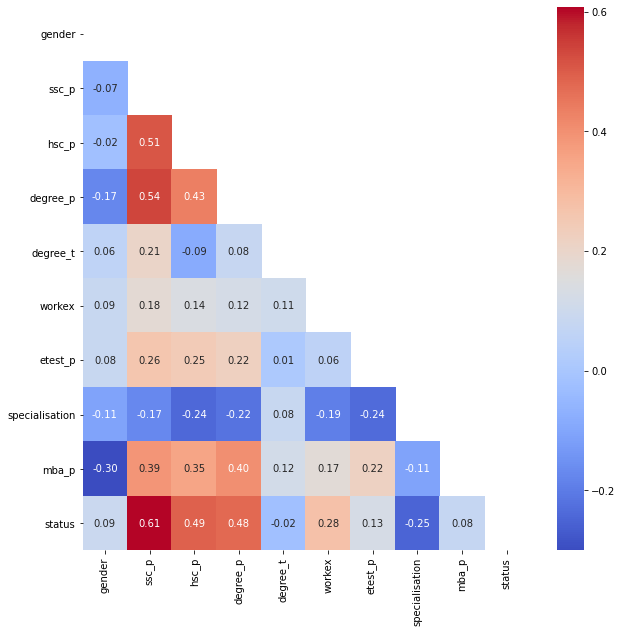

In [79]:
keephalf = np.zeros_like(corr)
keephalf[np.triu_indices_from(keephalf)] = True
plt.figure(figsize=(10,10))
sns.heatmap(corr, cmap='coolwarm', annot=True, fmt=".2f", mask=keephalf);

In [80]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0, shuffle = True, stratify = data['status'])

In [96]:
from sklearn.model_selection import GridSearchCV
param_grid = {'n_estimators': np.arange(100, 1000, 100), 'min_samples_leaf':np.arange(1, 100, 10), 'max_depth':np.arange(1, 10, 1)}
model = GradientBoostingClassifier(random_state = 0)
grid = GridSearchCV(model, param_grid=param_grid, cv=5)
grid.fit(X_train, y_train)
print(grid.best_params_)

{'max_depth': 2, 'min_samples_leaf': 1, 'n_estimators': 200}


In [92]:
from sklearn.model_selection import cross_val_score
model = GradientBoostingClassifier(random_state = 0, max_depth = 2, min_samples_leaf = 1, n_estimators = 200)
model.fit(X_train, y_train)
cross_val_score(model, X_train, y_train, scoring="accuracy", cv=5, n_jobs=-1)

array([0.78787879, 0.84375   , 0.9375    , 0.90625   , 0.875     ])

In [93]:
import pickle
pickl = {
    'work_encoder': encoders['workex'], 
    'gender_encoder': encoders['gender'],
    'degree_encoder': encoders['degree_t'],
    'spec_encoder': encoders['specialisation'],
    'classifier': model,
}
pickle.dump( pickl, open( 'models' + ".p", "wb" ) )